# Cluster 17

In [1]:
import gizmo_analysis as gizmo
import utilities as ut
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
from sl_utilities import distinct_colours as dc
from sl_utilities import distance_functions
import os
import pickle
from fof_analysis import fof
from mycolorpy import colorlist as mcp
from matplotlib.ticker import AutoMinorLocator


In [2]:
!hostname
!pwd
!pip show mycolorpy

c506-091.stampede2.tacc.utexas.edu
/home1/07428/binod
Name: mycolorpy
Version: 0.4.1
Summary: Create of array of colors from a colormap
Home-page: https://github.com/binodbhttr/mycolorpy
Author: Binod Bhattarai
Author-email: info@binodb.com.np
License: MIT
Location: /home1/07428/binod/anaconda3/lib/python3.8/site-packages
Requires: numpy, matplotlib
Required-by: 


In [3]:
simname = 'm12i_res7100_mhdcv'
simdir = '/scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/'
simtype="fire2"
snapnumber=630
snap=snapnumber

#data_path="/home1/07428/binod/stampede_workfolder/fire2/fire2_data_pkl/" 
#gas_datapath="/home1/07428/binod/stampede_workfolder/fire2/fire2_gas_data_pkl/"

#gas_file_name=simtype+"_gas_data"+str(snapnumber)+".pkl"
#cluster_data_name="all_clusters_at_snapshot_"+str(snapnumber)+".pkl" 

#############################################################################
#constants
#############################################################################

MsunToGm = 1.99e33
KpcToCm = 3.086e21
mp = 1.67e-24
#bin_edge = 10.
bin_edge = 30.

bins = np.arange(-5,5,0.1)
#bins = np.arange(-25,25,0.1)


# Extracting age, location and metallicity information for the simulations

In [4]:
part=gizmo.io.Read.read_snapshots(['star'],'snapshot_index', snap, simulation_name=simname, simulation_directory=simdir, assign_hosts=True, assign_hosts_rotation=True)               #snap is the snapshot number here that changes everytime the loop iterates. It starts with sanpshot_start

age=part['star'].prop('age')
x=part['star'].prop('host.distance.principal')[:,0] #x component of the position of all stars 
y=part['star'].prop('host.distance.principal')[:,1] #y component of the position of all stars
z=part['star'].prop('host.distance.principal')[:,2] #z component of the position of all stars
Rxy = part['star'].prop('host.distance.principal.cylindrical')[:,0]
rxyz     = part['star'].prop('host.distance.total')
mass     = part['star'].prop('mass')

ids      = part['star'].prop('id')
id_child = part['star'].prop('id.child')
age      = part['star'].prop('age')
#Eleven total chemical species (H, He, C, N, O, Ne, Mg, Si, S, Ca, Fe)
ch      = part['star'].prop('metallicity.c')
nh      = part['star'].prop('metallicity.n')
oh      = part['star'].prop('metallicity.o') #oxygen
neh      = part['star'].prop('metallicity.ne')
mgh = part['star'].prop('metallicity.mg') #magnesium
sih      = part['star'].prop('metallicity.si') # silicon
sh      = part['star'].prop('metallicity.s')
cah      = part['star'].prop('metallicity.ca') #calcium
feh = part['star'].prop('metallicity.fe') #iron
mgfe    = part['star'].prop('metallicity.mg - metallicity.fe')
sife    = part['star'].prop('metallicity.si - metallicity.fe')
cafe    = part['star'].prop('metallicity.ca - metallicity.fe')
ofe    = part['star'].prop('metallicity.o - metallicity.fe')
sfe    = part['star'].prop('metallicity.s - metallicity.fe')
nefe    = part['star'].prop('metallicity.ne - metallicity.fe')


# in utilities.simulation.Snapshot():
* reading:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/snapshot_times.txt

  using snapshot index = 630, redshift = 0.005


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/output/snapdir_630/snapshot_630.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 55657118 particles
    star      (id = 4): 15330379 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    snapshot_630.0.hdf5
    snapshot_630.1.hdf5
    snapshot_630.2.hdf5
    snapshot_630.3.hdf5

* reading cosmological parameters from:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/initial_condition/ic_agora_m12i.conf

* checking sanity of particle properties
! warning: star

In [5]:
#select young stars within the disk for star clusters
keep = np.where((age <= .003) & ((Rxy < 20) & (Rxy>2)) & (abs(z) < 1.5))
#to run cluster finding on
rxyz0     = rxyz[keep]
Rxy0      = Rxy[keep]
x0        = x[keep]
y0        = y[keep]
z0        = z[keep]
mass0     = mass[keep]
feh0      = feh[keep]
mgh0      = mgh[keep]
ch0=ch[keep]
nh0=nh[keep]
oh0=oh[keep]
neh0=neh[keep]
sih0=sih[keep]
sh0=sh[keep]
cah0=cah[keep]
mgfe0=mgfe[keep]
ofe0=ofe[keep]
sife0=sife[keep]
cafe0=cafe[keep]
sfe0=sfe[keep]
nefe0=nefe[keep]
id0       = ids[keep]
id_child0 = id_child[keep]
age0      = age[keep]

In [6]:
linking_length = 0.01 #10 parsec (unit here is in kpc)
ncut           = 10 #5 star particles
ind, xcm, ycm, zcm, mtot, grpid, r90, r50, rmax =fof.find(x0,y0,z0, b=linking_length, mass=mass0, ncut=ncut)
ngroup = len(mtot)

linking length  0.01
min number particles in group  10
0.14625787734985352 seconds
number of groups 20
max number in a group 78


# Loading cluster data and gas data

In [7]:
export_cluster={}
for grp_index in range(ngroup):  #iterate over each group
    cluster={}
    ids_in_cluster = id0[ind[grp_index]]  #these are the star particle ids in each cluster
    id_children_in_cluster = id_child0[ind[grp_index]]
    age_cluster=age0[ind[grp_index]]
    nstar = len(ids_in_cluster)
    groupid=grpid[grp_index]
    print('------------------------------------------------------------------------------------------------------------------')
    print('grpid, nstar, xcm (kpc), ycm (kpc), zcm (kpc), mtot (msun), rmax (pc)')
    print('%s     %i     %.4f     %.4f    %.4f     %.2e     %.1f ' % (grpid[grp_index], nstar, xcm[grp_index], ycm[grp_index], zcm[grp_index], mtot[grp_index], 1000*rmax[grp_index]))
    print("age of stars in the cluster",age_cluster)
    print('ids')
    string = '[' 
    for i in ids_in_cluster:
        string = string + str(i) + ', '

    #get rid of last extra ,
    length = len(string)-2
    string = string[0:length] + ']'
    print(string)

    print('id children')
    string = '[' 
    for i in id_children_in_cluster:
        string = string + str(i) + ', '

    #get rid of last extra ,
    length = len(string)-2
    string = string[0:length] + ']'
    print(string)
    print("These are the ids printed",ids_in_cluster)
    #feh_in_cluster=feh0[ind[grp_index]]
    #cluster={"cluster_groupid":groupid,"no_of_star":nstar,"id":ids_in_cluster,"id_children":id_children_in_cluster,"xcm":xcm[grp_index],"ycm":ycm[grp_index],"zcm":zcm[grp_index],"mtot":mtot[grp_index],"r90":r90[grp_index],"r50":r50[grp_index],"rmax":rmax[grp_index],"x":x0[ind[grp_index]],"y":y0[ind[grp_index]],"z":z0[ind[grp_index]],"age":age0[ind[grp_index]],"feh":feh0[ind[grp_index]],"mgh":mgh0[ind[grp_index]],"ch":ch0[ind[grp_index]],"nh":nh0[ind[grp_index]],"oh":oh0[ind[grp_index]],"neh":neh0[ind[grp_index]],"sih":sih0[ind[grp_index]],"sh":sh0[ind[grp_index]],"cah":cah0[ind[grp_index]],"mgfe":mgfe0[ind[grp_index]],"ofe":ofe0[ind[grp_index]],"sife":sife0[ind[grp_index]],"sfe":sfe0[ind[grp_index]],"cafe":cafe0[ind[grp_index]],"nefe":nefe0[ind[grp_index]]}
    cluster={"cluster_groupid":groupid,"no_of_star":nstar,"id":ids_in_cluster,"id_children":id_children_in_cluster,"xcm":xcm[grp_index],"ycm":ycm[grp_index],"zcm":zcm[grp_index],"mtot":mtot[grp_index],"r90":r90[grp_index],"r50":r50[grp_index],"rmax":rmax[grp_index],"x":x0[ind[grp_index]],"y":y0[ind[grp_index]],"z":z0[ind[grp_index]],"age":age0[ind[grp_index]],"feh":feh0[ind[grp_index]],"mgh":mgh0[ind[grp_index]],"ch":ch0[ind[grp_index]],"nh":nh0[ind[grp_index]],"oh":oh0[ind[grp_index]],"neh":neh0[ind[grp_index]],"sih":sih0[ind[grp_index]],"sh":sh0[ind[grp_index]],"cah":cah0[ind[grp_index]],"mgfe":mgfe0[ind[grp_index]],"ofe":ofe0[ind[grp_index]],"sife":sife0[ind[grp_index]],"sfe":sfe0[ind[grp_index]],"cafe":cafe0[ind[grp_index]],"nefe":nefe0[ind[grp_index]]}
    export_cluster.update({groupid:cluster})


------------------------------------------------------------------------------------------------------------------
grpid, nstar, xcm (kpc), ycm (kpc), zcm (kpc), mtot (msun), rmax (pc)
1     78     -6.0114     1.7792    0.0157     8.74e+05     37.7 
age of stars in the cluster [0.00167086 0.00292154 0.00283993 0.00253184 0.0029765  0.00291155
 0.00258346 0.00254266 0.00160924 0.00254266 0.00241943 0.00266007
 0.00273751 0.00298815 0.00291821 0.0027475  0.00261427 0.00295152
 0.00286575 0.00299898 0.00274251 0.00273751 0.00266007 0.00265008
 0.00267589 0.00258346 0.00249104 0.00268589 0.00218378 0.00283494
 0.00286575 0.00249104 0.00288573 0.00269588 0.00216296 0.00245023
 0.00257347 0.0022862  0.00284493 0.0024086  0.00212216 0.00280996
 0.00211134 0.0027983  0.00280912 0.0027575  0.00206054 0.00185487
 0.00277831 0.00273751 0.00212216 0.002327   0.00249104 0.00128118
 0.00185487 0.00288074 0.00136278 0.00271669 0.00140358 0.00138359
 0.00242942 0.00170666 0.00128118 0.00136278 0.00136

In [8]:
cluster_group=1
export_cluster[cluster_group].keys()

dict_keys(['cluster_groupid', 'no_of_star', 'id', 'id_children', 'xcm', 'ycm', 'zcm', 'mtot', 'r90', 'r50', 'rmax', 'x', 'y', 'z', 'age', 'feh', 'mgh', 'ch', 'nh', 'oh', 'neh', 'sih', 'sh', 'cah', 'mgfe', 'ofe', 'sife', 'sfe', 'cafe', 'nefe'])

In [9]:
ind=export_cluster[1]["feh"]
print(feh)
print(export_cluster[1]["x"])
print(export_cluster[1]["r90"])


[-0.8148875  -0.55647886 -0.9978042  ... -0.9496935  -1.2350649
 -1.5900397 ]
[-5.99739175 -5.9947293  -6.00583159 -6.0030985  -6.00582074 -5.99921476
 -5.99191559 -5.99907357 -5.99636693 -5.99405573 -5.99817777 -5.99728365
 -6.00245742 -6.00739696 -6.00683357 -6.00062147 -6.00855314 -6.00583925
 -6.00268235 -6.00852316 -6.00154722 -5.99960271 -5.9930225  -5.9929759
 -5.99237134 -5.98804132 -5.99329205 -5.99123407 -6.00544948 -5.99697511
 -6.00037067 -5.99595652 -6.00161265 -6.00515611 -6.00456452 -5.98641355
 -5.98705687 -5.99346335 -5.99159008 -6.01247707 -5.98233185 -5.98706876
 -6.00962486 -6.01541216 -6.01469982 -6.01485949 -5.97514962 -5.98852174
 -6.00864171 -6.02088495 -6.02263591 -6.02300807 -6.03205579 -6.03341233
 -6.0301121  -6.03337961 -6.03097338 -6.02911691 -6.02755605 -6.02931155
 -6.02329336 -6.02888626 -6.02896846 -6.03004664 -6.03082993 -6.02539381
 -6.0336522  -6.03566124 -6.01775964 -6.03441723 -6.03304146 -6.03661531
 -6.03965753 -6.0325405  -6.03839758 -6.0307190

# Locating the CM of the cluster

In [10]:
xcm=export_cluster[cluster_group]["xcm"]
ycm=export_cluster[cluster_group]["ycm"]
print("The cluster is located at:",(xcm,ycm))
radius=((xcm)**2+(ycm)**2)**(1/2)
print("The cluster CM is at radius: ",radius)

circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
print(len(circle_radius))

cm_R=list()
for i in export_cluster:
    xcm=export_cluster[i]["xcm"]
    ycm=export_cluster[i]["ycm"]
    radius=((xcm)**2+(ycm)**2)**(1/2)
    cm_R.append(radius)
    

print(cm_R)
cm_R=np.array(cm_R)


The cluster is located at: (-6.011359706393289, 1.7792465859492033)
The cluster CM is at radius:  6.26914379586724
15330379
[6.26914379586724, 13.922488454921112, 6.485362468013994, 6.259774384978781, 10.007109591464552, 6.4842931068404255, 7.970126825390916, 6.322678964217267, 6.560057536009463, 6.270109348246739, 6.358547357567959, 6.27446952939802, 4.5098863282949875, 3.7384379348149577, 8.894251095020255, 13.70759203865414, 6.754599604099548, 6.47816956672352, 3.779795740856501, 6.266432360465232]


In [11]:
region=np.linspace(1,20,20)/10
print(region)
print(cluster_group)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
1


# Age less than 3 Myr


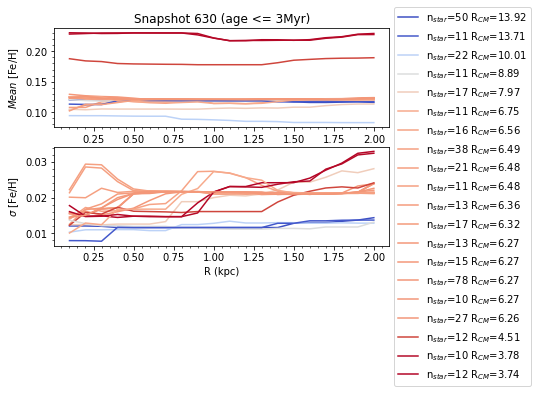

In [12]:
#colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
colors=mcp.gen_color_normalized(cmap="coolwarm",data_arr=cm_R,reverse=True)
fig1=plt.figure()
ax=fig1.add_subplot(212)
ax0=fig1.add_subplot(211)

for cluster_group in export_cluster:
    sigma_f=list()
    mean_f=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_feh=export_cluster[cluster_group]["feh"]
    cluster_feh_sigma=np.std(cluster_feh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    #print("The cluster CM is at radius: ",round(radius,2))
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .003) & (circle_radius<=r) & (abs(z) < 1.5))
        feh_region=feh[keep]
        sigma_feh_region=np.std(feh_region)
        mean_feh_region=np.mean(feh_region)
        sigma_f.append(sigma_feh_region)
        mean_f.append(mean_feh_region)

    #print(sigma_f)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    ax.plot(region,sigma_f,label=label_text,c=colors[cluster_group-1])
    ax0.plot(region,mean_f,label=label_text,c=colors[cluster_group-1])

    #ax.scatter(r90_cluster,cluster_feh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\sigma$ [Fe/H]")
ax.minorticks_on()

handles,labels = ax.get_legend_handles_labels()
sorted_handles= [x for _,x in sorted(zip(cm_R,handles),reverse=True)] #sort the handles (the colors next to the labels) based on location of CM
sorted_legends= [x for _,x in sorted(zip(cm_R,labels),reverse=True)] #sort the labels based on cm_R which is a list
ax.legend(sorted_handles,sorted_legends,bbox_to_anchor=(1,0.5), loc='center left')

ax0.set_title("Snapshot "+str(snapnumber)+" (age <= 3Myr)")
#ax0.set_xlabel("R (kpc)")
ax0.set_ylabel(r"$Mean$ [Fe/H]")
ax0.minorticks_on()
fig1.savefig(str(snapnumber)+"sigma_feh_Age3Myr.jpg",bbox_inches='tight',dpi=200)
plt.show()

# SIGMA Fe/H Age<=10 Myr

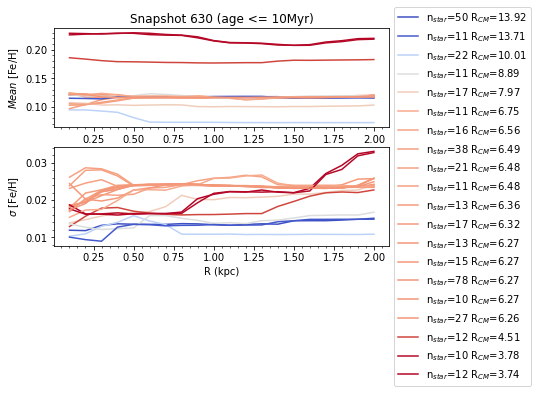

In [13]:
#colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
colors=mcp.gen_color_normalized(cmap="coolwarm",data_arr=cm_R,reverse=True)
fig1=plt.figure()
ax=fig1.add_subplot(212)
ax0=fig1.add_subplot(211)

for cluster_group in export_cluster:
    sigma_f=list()
    mean_f=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_feh=export_cluster[cluster_group]["feh"]
    cluster_feh_sigma=np.std(cluster_feh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    #print("The cluster CM is at radius: ",round(radius,2))
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .010) & (circle_radius<=r) & (abs(z) < 1.5))
        feh_region=feh[keep]
        sigma_feh_region=np.std(feh_region)
        mean_feh_region=np.mean(feh_region)
        sigma_f.append(sigma_feh_region)
        mean_f.append(mean_feh_region)

    #print(sigma_f)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    ax.plot(region,sigma_f,label=label_text,c=colors[cluster_group-1])
    ax0.plot(region,mean_f,label=label_text,c=colors[cluster_group-1])

    #ax.scatter(r90_cluster,cluster_feh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\sigma$ [Fe/H]")
ax.minorticks_on()

handles,labels = ax.get_legend_handles_labels()
sorted_handles= [x for _,x in sorted(zip(cm_R,handles),reverse=True)] #sort the handles (the colors next to the labels) based on location of CM
sorted_legends= [x for _,x in sorted(zip(cm_R,labels),reverse=True)] #sort the labels based on cm_R which is a list
ax.legend(sorted_handles,sorted_legends,bbox_to_anchor=(1,0.5), loc='center left')

ax0.set_title("Snapshot "+str(snapnumber)+" (age <= 10Myr)")
#ax0.set_xlabel("R (kpc)")
ax0.set_ylabel(r"$Mean$ [Fe/H]")
ax0.minorticks_on()
fig1.savefig(str(snapnumber)+"sigma_feh_age10Myr.jpg",bbox_inches='tight',dpi=200)
plt.show()

# Sigma over root N age <=3 Myr 

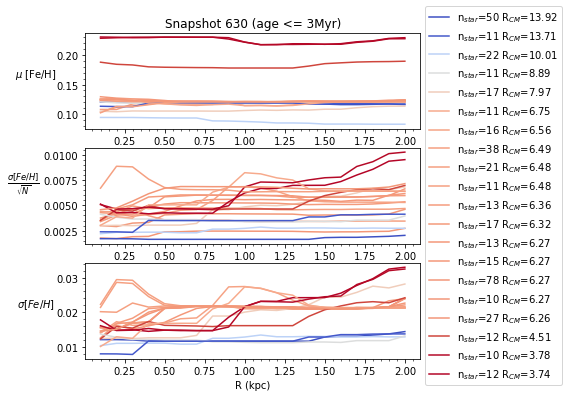

In [14]:
#colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
colors=mcp.gen_color_normalized(cmap="coolwarm",data_arr=cm_R,reverse=True)
fig1=plt.figure(figsize=(6,6))
ax=fig1.add_subplot(312)
ax0=fig1.add_subplot(311)
ax1=fig1.add_subplot(313)


for cluster_group in export_cluster:
    sigma_f=list()
    mean_f=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_feh=export_cluster[cluster_group]["feh"]
    cluster_feh_sigma=np.std(cluster_feh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    #print("The cluster CM is at radius: ",round(radius,2))
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .003) & (circle_radius<=r) & (abs(z) < 1.5))
        feh_region=feh[keep]
        sigma_feh_region=np.std(feh_region)
        mean_feh_region=np.mean(feh_region)
        sigma_f.append(sigma_feh_region)
        mean_f.append(mean_feh_region)

    #print(sigma_f)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    sigma_f_rootN=np.array(sigma_f)/(nstar**(1/2))
    ax.plot(region,sigma_f_rootN,label=label_text,c=colors[cluster_group-1])
    ax0.plot(region,mean_f,label=label_text,c=colors[cluster_group-1])
    ax1.plot(region,sigma_f,label=label_text,c=colors[cluster_group-1])
    #ax.scatter(r90_cluster,cluster_feh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\frac{\sigma [Fe/H]}{\sqrt{N}}$",fontsize=12,rotation=0,labelpad=20)
ax.minorticks_on()

ax1.set_xlabel("R (kpc)")
ax1.set_ylabel(r"$\sigma [Fe/H]$",rotation=0,labelpad=20)
ax1.minorticks_on()

handles,labels = ax.get_legend_handles_labels()
sorted_handles= [x for _,x in sorted(zip(cm_R,handles),reverse=True)] #sort the handles (the colors next to the labels) based on location of CM
sorted_legends= [x for _,x in sorted(zip(cm_R,labels),reverse=True)] #sort the labels based on cm_R which is a list
ax.legend(sorted_handles,sorted_legends,bbox_to_anchor=(1,0.5), loc='center left')

ax0.set_title("Snapshot "+str(snapnumber)+" (age <= 3Myr)")
#ax0.set_xlabel("R (kpc)")
ax0.set_ylabel(r"$\mu$ [Fe/H]",rotation=0,labelpad=20)
ax0.minorticks_on()
fig1.savefig(str(snapnumber)+"sigma_feh_by_rootN_region_2kpc_Age_3Myr.jpg",dpi=200,bbox_inches="tight") #bbox_inches="tight"
plt.show()

# Sigma over root N (age <10 Myr)

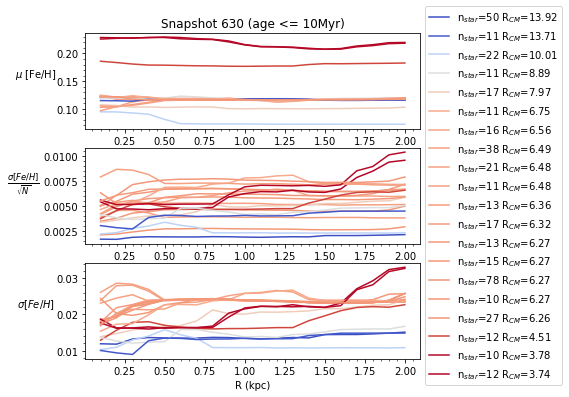

In [15]:
#colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
colors=mcp.gen_color_normalized(cmap="coolwarm",data_arr=cm_R,reverse=True)
fig1=plt.figure(figsize=(6,6))
ax=fig1.add_subplot(312)
ax0=fig1.add_subplot(311)
ax1=fig1.add_subplot(313)


for cluster_group in export_cluster:
    sigma_f=list()
    mean_f=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_feh=export_cluster[cluster_group]["feh"]
    cluster_feh_sigma=np.std(cluster_feh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    #print("The cluster CM is at radius: ",round(radius,2))
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .010) & (circle_radius<=r) & (abs(z) < 1.5))
        feh_region=feh[keep]
        sigma_feh_region=np.std(feh_region)
        mean_feh_region=np.mean(feh_region)
        sigma_f.append(sigma_feh_region)
        mean_f.append(mean_feh_region)

    #print(sigma_f)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    sigma_f_rootN=np.array(sigma_f)/(nstar**(1/2))
    ax.plot(region,sigma_f_rootN,label=label_text,c=colors[cluster_group-1])
    ax0.plot(region,mean_f,label=label_text,c=colors[cluster_group-1])
    ax1.plot(region,sigma_f,label=label_text,c=colors[cluster_group-1])
    #ax.scatter(r90_cluster,cluster_feh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\frac{\sigma [Fe/H]}{\sqrt{N}}$",fontsize=12,rotation=0,labelpad=20)
ax.minorticks_on()

ax1.set_xlabel("R (kpc)")
ax1.set_ylabel(r"$\sigma [Fe/H]$",rotation=0,labelpad=20)
ax1.minorticks_on()

handles,labels = ax.get_legend_handles_labels()
sorted_handles= [x for _,x in sorted(zip(cm_R,handles),reverse=True)] #sort the handles (the colors next to the labels) based on location of CM
sorted_legends= [x for _,x in sorted(zip(cm_R,labels),reverse=True)] #sort the labels based on cm_R which is a list
ax.legend(sorted_handles,sorted_legends,bbox_to_anchor=(1,0.5), loc='center left')

ax0.set_title("Snapshot "+str(snapnumber)+" (age <= 10Myr)")
#ax0.set_xlabel("R (kpc)")
ax0.set_ylabel(r"$\mu$ [Fe/H]",rotation=0,labelpad=20)
ax0.minorticks_on()
fig1.savefig(str(snapnumber)+"sigma_feh_by_rootN_region_2kpc_Age_10Myr.jpg",dpi=200,bbox_inches="tight") #bbox_inches="tight"
plt.show()

# Mgh

The cluster CM is at radius:  6.26914379586724
The cluster CM is at radius:  13.922488454921112
The cluster CM is at radius:  6.485362468013994
The cluster CM is at radius:  6.259774384978781
The cluster CM is at radius:  10.007109591464552
The cluster CM is at radius:  6.4842931068404255
The cluster CM is at radius:  7.970126825390916
The cluster CM is at radius:  6.322678964217267
The cluster CM is at radius:  6.560057536009463
The cluster CM is at radius:  6.270109348246739
The cluster CM is at radius:  6.358547357567959
The cluster CM is at radius:  6.27446952939802
The cluster CM is at radius:  4.5098863282949875
The cluster CM is at radius:  3.7384379348149577
The cluster CM is at radius:  8.894251095020255
The cluster CM is at radius:  13.70759203865414
The cluster CM is at radius:  6.754599604099548
The cluster CM is at radius:  6.47816956672352
The cluster CM is at radius:  3.779795740856501
The cluster CM is at radius:  6.266432360465232


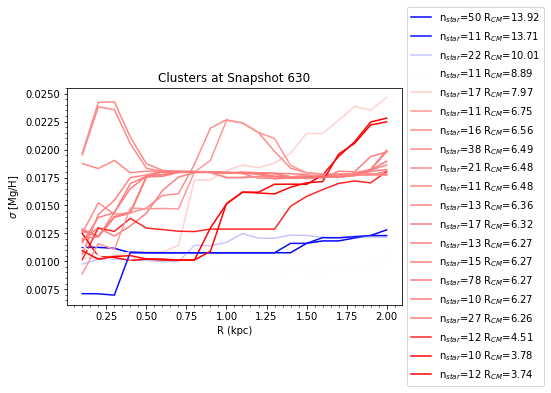

In [16]:
#colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
colors=mcp.gen_color_normalized(cmap="bwr",data_arr=cm_R,reverse=True)

fig1=plt.figure()
ax=fig1.add_subplot(111)

for cluster_group in export_cluster:
    sigma_mgh=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_mgh=export_cluster[cluster_group]["mgh"]
    cluster_mgh_sigma=np.std(cluster_mgh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    print("The cluster CM is at radius: ",radius)
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .003) & (circle_radius<=r) & (abs(z) < 1.5))
        mgh_region=mgh[keep]
        sigma_mgh_region=np.std(mgh_region)
        sigma_mgh.append(sigma_mgh_region)

    #print(sigma_mgh)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    ax.plot(region,sigma_mgh,label=label_text,c=colors[cluster_group-1])
    #ax.scatter(r90_cluster,cluster_mgh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\sigma$ [Mg/H]")
ax.minorticks_on()
handles,labels = ax.get_legend_handles_labels()
sorted_handles= [x for _,x in sorted(zip(cm_R,handles),reverse=True)] #sort the handles (the colors next to the labels) based on location of CM
sorted_legends= [x for _,x in sorted(zip(cm_R,labels),reverse=True)] #sort the labels based on cm_R which is a list
ax.legend(sorted_handles,sorted_legends,bbox_to_anchor=(1,0.5), loc='center left')
ax.set_title("Clusters at Snapshot "+str(snapnumber))
fig1.savefig(str(snapnumber)+"sigma_mgh_region_new_data_3Myr.jpg",bbox_inches='tight',dpi=200)

# Metallicities of clusters

In [17]:
export_cluster[1].keys()
#export_cluster[1]["feh"]
print(export_cluster[1]["age"])

[0.00167086 0.00292154 0.00283993 0.00253184 0.0029765  0.00291155
 0.00258346 0.00254266 0.00160924 0.00254266 0.00241943 0.00266007
 0.00273751 0.00298815 0.00291821 0.0027475  0.00261427 0.00295152
 0.00286575 0.00299898 0.00274251 0.00273751 0.00266007 0.00265008
 0.00267589 0.00258346 0.00249104 0.00268589 0.00218378 0.00283494
 0.00286575 0.00249104 0.00288573 0.00269588 0.00216296 0.00245023
 0.00257347 0.0022862  0.00284493 0.0024086  0.00212216 0.00280996
 0.00211134 0.0027983  0.00280912 0.0027575  0.00206054 0.00185487
 0.00277831 0.00273751 0.00212216 0.002327   0.00249104 0.00128118
 0.00185487 0.00288074 0.00136278 0.00271669 0.00140358 0.00138359
 0.00242942 0.00170666 0.00128118 0.00136278 0.00136278 0.00142439
 0.00179409 0.00261427 0.00138359 0.00192149 0.00181407 0.00181407
 0.00224456 0.00195479 0.00189151 0.00167086 0.00195479 0.00177327]


In [13]:
def getmetal(export_cluster,metal):
    all_metal=list()
    for cluster_group in export_cluster:
        metal_data=export_cluster[cluster_group][metal]
        all_metal.append(list(metal_data))
    
    return all_metal

In [14]:
metal="feh"
all_metal=list()
age=list()
for cluster_group in export_cluster:
    metal_data=export_cluster[cluster_group][metal]
    all_metal.append(list(metal_data))
    age_cluster=np.mean(export_cluster[cluster_group]["age"])
    age.append(age_cluster)
#print(all_metal)
print(age)

[0.002333376889417297, 0.0014360203351878554, 0.0008113620870223539, 0.0019575108413020523, 0.0005343488059471501, 0.001255450695422597, 0.0012706002593891614, 0.00034065329805772353, 0.0011517017389951478, 0.0006412179723596978, 0.0004461815842865108, 0.0012687512581622902, 0.001009256026906158, 0.0009477113552716077, 0.0012903386400680006, 0.002439715819936436, 0.0008304959609111959, 0.0010311602099312852, 0.0026172727053985767, 0.0007704449969677896]


<ipython-input-16-b3a401ece90e>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig2.tight_layout()


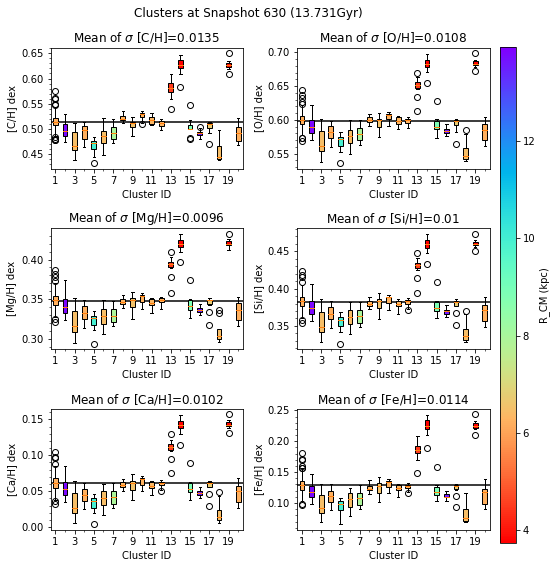

In [16]:
fig2=plt.figure(figsize=(7,8))

'''
ax_c=fig2.add_subplot(321)
ax_o=fig2.add_subplot(322)
ax_mg=fig2.add_subplot(323)
ax_si=fig2.add_subplot(324)
ax_ca=fig2.add_subplot(325)
ax_fe=fig2.add_subplot(326)
'''
cluster_id=np.arange(1,len(export_cluster)+1,1)

metals=["ch","oh","mgh","sih","cah","feh"]
metal_label=["[C/H]","[O/H]","[Mg/H]","[Si/H]","[Ca/H]","[Fe/H]"]

colors=mcp.gen_color_normalized(cmap="rainbow",data_arr=cm_R,reverse=True)
x=np.arange(1,21,1)


for i in range(len(metals)):
    ax=fig2.add_subplot(3,2,i+1)
    all_metal=getmetal(export_cluster,metals[i])
    box=ax.boxplot(all_metal,patch_artist=True)
    cluster_means=[np.mean(each_cluster) for each_cluster in np.array(all_metal,dtype=list)]
    cluster_stds=[np.std(each_cluster)for each_cluster in np.array(all_metal,dtype=list)]
    ax.axhline(y=np.mean(cluster_means),c="black",label="Mean Metallicity")
    mean_std=np.mean(cluster_stds)
    ax.set_title(r"Mean of $\sigma$ "+metal_label[i]+"="+str(round(mean_std,4)))
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel(metal_label[i]+str(" dex"))
    ax.minorticks_on()
    ax.set_xticks(x[::2])
    ax.set_xticklabels(x[::2], rotation=0)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)


import matplotlib as mpl
ax = fig2.add_axes([1, 0.05, 0.03, 0.86]) #left, bottom, width, height
norm=mpl.colors.Normalize(np.min(np.array(cm_R)), np.max(np.array(cm_R)))
cb = mpl.colorbar.ColorbarBase(ax, orientation='vertical',
        cmap=mpl.cm.rainbow_r,norm=norm
        ,label="R_CM (kpc)")

'''
ax_c.boxplot(getmetal(export_cluster,"ch"),patch_artist=True)
ax_o.boxplot(getmetal(export_cluster,"oh"),patch_artist=True)
ax_mg.boxplot(getmetal(export_cluster,"mgh"),patch_artist=True)
ax_si.boxplot(getmetal(export_cluster,"sih"),patch_artist=True)
ax_ca.boxplot(getmetal(export_cluster,"cah"),patch_artist=True)
ax_fe.boxplot(getmetal(export_cluster,"feh"),patch_artist=True)
'''
fig2.suptitle("Clusters at Snapshot "+str(snapnumber)+" ("+str(round(part.snapshot["time"],3))+"Gyr)")
fig2.tight_layout()
fig2.savefig("Metallicities_Clusters_with_R_CM"+str(snapnumber)+".jpg",bbox_inches="tight",dpi=200)






# Metallicites of the clusters color coded with Fe/H

<ipython-input-15-51841d90df70>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig3.tight_layout()


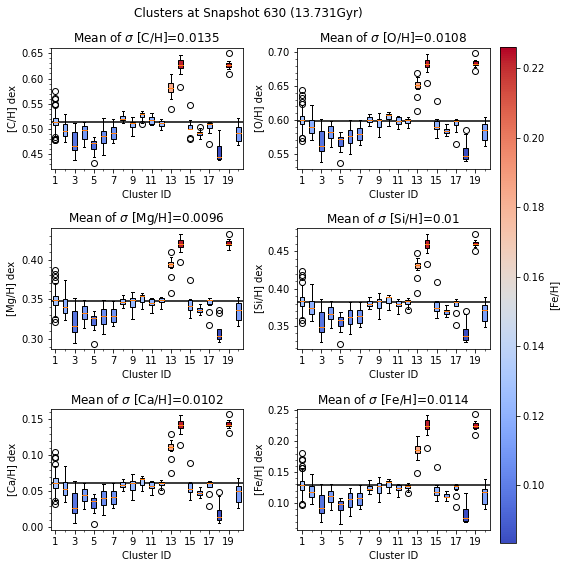

In [15]:
fig3=plt.figure(figsize=(7,8))

'''
ax_c=fig3.add_subplot(321)
ax_o=fig3.add_subplot(322)
ax_mg=fig3.add_subplot(323)
ax_si=fig3.add_subplot(324)
ax_ca=fig3.add_subplot(325)
ax_fe=fig3.add_subplot(326)
'''
cluster_id=np.arange(1,len(export_cluster)+1,1)

metals=["ch","oh","mgh","sih","cah","feh"]
metal_label=["[C/H]","[O/H]","[Mg/H]","[Si/H]","[Ca/H]","[Fe/H]"]

feh_clusters=getmetal(export_cluster,"feh")
feh_means=[np.mean(each_cluster) for each_cluster in np.array(feh_clusters,dtype=list)]
colors_Fe_H=mcp.gen_color_normalized(cmap="coolwarm",data_arr=np.array(feh_means))
x=np.arange(1,21,1)


for i in range(len(metals)):
    ax=fig3.add_subplot(3,2,i+1)
    all_metal=getmetal(export_cluster,metals[i])
    box=ax.boxplot(all_metal,patch_artist=True)
    cluster_means=[np.mean(each_cluster) for each_cluster in np.array(all_metal,dtype=list)]
    cluster_stds=[np.std(each_cluster)for each_cluster in np.array(all_metal,dtype=list)]
    ax.axhline(y=np.mean(cluster_means),c="black",label="Mean Metallicity")
    mean_std=np.mean(cluster_stds)
    ax.set_title(r"Mean of $\sigma$ "+metal_label[i]+"="+str(round(mean_std,4)))
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel(metal_label[i]+str(" dex"))
    ax.minorticks_on()
    ax.set_xticks(x[::2])
    ax.set_xticklabels(x[::2], rotation=0)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)

    for patch, color in zip(box['boxes'], colors_Fe_H):
        patch.set_facecolor(color)


import matplotlib as mpl
ax = fig3.add_axes([1, 0.05, 0.03, 0.86]) #left, bottom, width, height
norm=mpl.colors.Normalize(np.min(np.array(feh_means)), np.max(np.array(feh_means)))
cb = mpl.colorbar.ColorbarBase(ax, orientation='vertical',
        cmap=mpl.cm.coolwarm,norm=norm
        ,label="[Fe/H]")

'''
ax_c.boxplot(getmetal(export_cluster,"ch"),patch_artist=True)
ax_o.boxplot(getmetal(export_cluster,"oh"),patch_artist=True)
ax_mg.boxplot(getmetal(export_cluster,"mgh"),patch_artist=True)
ax_si.boxplot(getmetal(export_cluster,"sih"),patch_artist=True)
ax_ca.boxplot(getmetal(export_cluster,"cah"),patch_artist=True)
ax_fe.boxplot(getmetal(export_cluster,"feh"),patch_artist=True)
'''
fig3.suptitle("Clusters at Snapshot "+str(snapnumber)+" ("+str(round(part.snapshot["time"],3))+"Gyr)")
fig3.tight_layout()
fig3.savefig("Metallicities_Clusters_with_Fe_H"+str(snapnumber)+".jpg",bbox_inches="tight",dpi=200)


# R_CM vs Cluster ID color coded by metallicity and sized by mass

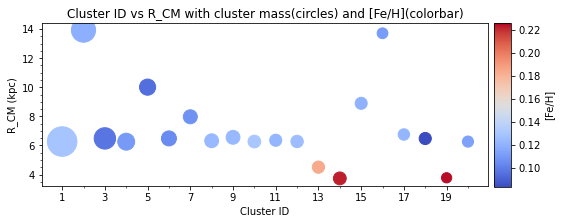

In [19]:
#Getting the mass of all clusters in  a list
all_mass=list()
for cluster_group in export_cluster:
    mass_data=export_cluster[cluster_group]["mtot"]
    all_mass.append(mass_data)
#print(all_mass)

fig5=plt.figure(figsize=(8,3))
cluster_id=np.arange(1,len(export_cluster)+1,1)
ax=fig5.add_subplot(1,1,1)

x=np.arange(1,len(export_cluster)+1,1)

ax.set_title("Cluster ID vs R_CM with cluster mass(circles) and [Fe/H](colorbar)")
ax.set_xlabel("Cluster ID")
ax.set_ylabel("R_CM (kpc)")
ax.minorticks_on()
ax.set_xticks(x[::2])
ax.set_xticklabels(x[::2], rotation=0)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.scatter(x,cm_R,c=colors_Fe_H,s=np.array(all_mass)/1e3)

import matplotlib as mpl
ax = fig5.add_axes([0.91, 0.12, 0.03, 0.76]) #left, bottom, width, height
norm=mpl.colors.Normalize(np.min(np.array(feh_means)), np.max(np.array(feh_means)))
cb = mpl.colorbar.ColorbarBase(ax, orientation='vertical',
        cmap=mpl.cm.coolwarm,norm=norm
        ,label="[Fe/H]")

fig5.savefig("Cluster_ID_vs_R_CM_with_Fe_H"+str(snapnumber)+".jpg",bbox_inches="tight",dpi=200)
